In [10]:
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
import os
from transformers import AutoTokenizer, AutoModelForCausalLM

In [11]:
def generate(text_in, tok_in, mod_in):
    tok_text = tok_in(text_in, return_tensors='pt').to('cuda:0')
    gen_text = mod_in.generate(**tok_text, max_new_tokens=512)
    dec_text = tok_in.decode(gen_text[0], skip_special_tokens=True)
    return dec_text

In [17]:
tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v0.3")


baseline_model = AutoModelForCausalLM.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v0.3", torch_dtype=torch.float32)
# rlhf_model = AutoModelForCausalLM.from_pretrained("../Reward Model/model/", torch_dtype=torch.float32)

Some weights of LlamaForCausalLM were not initialized from the model checkpoint at TinyLlama/TinyLlama-1.1B-Chat-v0.3 and are newly initialized: ['model.layers.11.self_attn.rotary_emb.inv_freq', 'model.layers.13.self_attn.rotary_emb.inv_freq', 'model.layers.7.self_attn.rotary_emb.inv_freq', 'model.layers.10.self_attn.rotary_emb.inv_freq', 'model.layers.15.self_attn.rotary_emb.inv_freq', 'model.layers.0.self_attn.rotary_emb.inv_freq', 'model.layers.17.self_attn.rotary_emb.inv_freq', 'model.layers.19.self_attn.rotary_emb.inv_freq', 'model.layers.16.self_attn.rotary_emb.inv_freq', 'model.layers.3.self_attn.rotary_emb.inv_freq', 'model.layers.21.self_attn.rotary_emb.inv_freq', 'model.layers.14.self_attn.rotary_emb.inv_freq', 'model.layers.5.self_attn.rotary_emb.inv_freq', 'model.layers.1.self_attn.rotary_emb.inv_freq', 'model.layers.4.self_attn.rotary_emb.inv_freq', 'model.layers.18.self_attn.rotary_emb.inv_freq', 'model.layers.8.self_attn.rotary_emb.inv_freq', 'model.layers.12.self_attn.r

In [4]:
baseline_model.to('cuda:0')

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32003, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-21): 22 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (up_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (down_proj): Linear(in_features=5632, out_features=2048, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()


In [12]:
df = pd.read_feather('../mini_codenet/data/split/evaluate_train.ftr')
df.head()

,level_0,index,submission_id,problem_id,language,filename_ext,status,cpu_time,memory,code_size,accuracy,solution,problem_statement
0,1619278,5172,s373894550,p03202,C++,cpp,Wrong Answer,2103.0,1916.0,2741,None,#include <bits/stdc++.h>\nusing namespace std;...,Score : 700 points \n Problem Statement There ...
1,771169,5835,s440823744,p03008,C++,cpp,Wrong Answer,176.0,256.0,1378,None,#include <bits/stdc++.h>\n\nusing namespace st...,Score : 600 points \n Problem Statement The sq...
2,1654494,7516,s716084373,p03943,Python,py,Wrong Answer,17.0,2940.0,88,None,"a, b, c = map(int, input().split())\n\nif a ==...",Score : 100 points \n Problem Statement Two st...
3,758900,5870,s029981993,p03047,Python,py,Accepted,17.0,2940.0,43,None,"n,k = map(int,input().split())\nprint(n-k+1)",Score : 100 points \n Problem Statement Snuke ...
4,2792852,1786,s487610428,p03852,Python,py,Accepted,168.0,38384.0,114,None,"c = input()\n\nif c == ""a"" or c == ""i"" or c ==...",Score : 100 points \n Problem Statement Given ...


In [13]:
eval_df = pd.read_feather('./file.feather')
eval_df.head()

,a,b
0,p02402,5\n10 1 5 4 17
1,p03316,12
2,p02995,4 9 2 3
3,p03129,3 2
4,p02612,1900


In [14]:
print(len(eval_df))

50


In [29]:
num_compiled = 0
num_checked = 0
dist = len(os.listdir('./baseline_files/'))
print(dist)
for pid in tqdm(set(eval_df['a'].values)):
    if num_checked >= dist-1:
        instance = df.loc[(df['status'] == 'Accepted') & (df['language'] == 'Python') & (df['problem_id'] == pid)]
        
        prompt = instance.iloc[0]['problem_statement']
        prompt = prompt.replace('\n', '')
        lang = instance.iloc[0]['language']
        # ------ baseline -------
        formatted_prompt = (f"<|im_start|>user\nGenerate the correct {lang} code to answer the following prompt that can also takens input and prints out an answer:{prompt}<|im_end|>\n<|im_start|>assistant\n")
        generated = generate(formatted_prompt, tokenizer, baseline_model)
        try:
            baseline_generated = re.search(f'```{lang.lower()}(\n|.)*```', generated).group()
        except:
            baseline_generated = re.search(f'```{lang.lower()}(\n|.)*```', generated+'```').group()
        #print(baseline_generated)
        try:
            open(f'./baseline_files/{num_checked}.txt', 'w', encoding="utf-8").write(baseline_generated)
        except:
            open(f'./baseline_files/{num_checked}.txt', 'w', encoding="utf-8").write(generated)
        try:
            x = compile(baseline_generated[3+len(lang):-3], 'test', 'exec')
            num_compiled += 1
            num_checked += 1
        except:
            num_checked += 1
            continue
    else:
        num_checked += 1
    #out = exec(x)
    #print(out)
# ------ finetuned -------
# formatted_prompt = (f"<|im_start|>user\n{prompt}<|im_end|>\n<|im_start|>assistantPython\n") # update this with newest model
# generated = generate(formatted_prompt, tokenizer, tuned_model)
# fine

28


100%|██████████| 50/50 [13:48<00:00, 16.58s/it]


In [15]:
tuned_model = AutoModelForCausalLM.from_pretrained("../finetuning/hf_model/", torch_dtype=torch.float32)
tuned_model.to('cuda:0')

Some weights of LlamaForCausalLM were not initialized from the model checkpoint at ../finetuning/hf_model/ and are newly initialized: ['model.layers.11.self_attn.rotary_emb.inv_freq', 'model.layers.13.self_attn.rotary_emb.inv_freq', 'model.layers.7.self_attn.rotary_emb.inv_freq', 'model.layers.10.self_attn.rotary_emb.inv_freq', 'model.layers.15.self_attn.rotary_emb.inv_freq', 'model.layers.0.self_attn.rotary_emb.inv_freq', 'model.layers.17.self_attn.rotary_emb.inv_freq', 'model.layers.19.self_attn.rotary_emb.inv_freq', 'model.layers.16.self_attn.rotary_emb.inv_freq', 'model.layers.3.self_attn.rotary_emb.inv_freq', 'model.layers.21.self_attn.rotary_emb.inv_freq', 'model.layers.14.self_attn.rotary_emb.inv_freq', 'model.layers.5.self_attn.rotary_emb.inv_freq', 'model.layers.1.self_attn.rotary_emb.inv_freq', 'model.layers.4.self_attn.rotary_emb.inv_freq', 'model.layers.18.self_attn.rotary_emb.inv_freq', 'model.layers.8.self_attn.rotary_emb.inv_freq', 'model.layers.12.self_attn.rotary_emb.i

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32003, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-21): 22 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (up_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (down_proj): Linear(in_features=5632, out_features=2048, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()


In [18]:
num_compiled = 0
num_checked = 0
dist = len(os.listdir('./finetune_files2/'))
print(dist)
for pid in tqdm(set(eval_df['a'].values)):
    if num_checked >= dist-1:
        instance = df.loc[(df['status'] == 'Accepted') & (df['language'] == 'Python') & (df['problem_id'] == pid)]
        
        prompt = instance.iloc[0]['problem_statement']
        prompt = prompt.replace('\n', '')
        lang = instance.iloc[0]['language']
        # ------ finetune -------
        formatted_prompt = (f"<|im_start|>user\n{prompt}<|im_end|>\n<|im_start|>assistant\n```python\n")        
        generated = generate(formatted_prompt, tokenizer, tuned_model)
        print(generated)
        try:
            finetune_generated = re.search(f'```{lang.lower()}(\n|.)*```', generated).group()
        except:
            finetune_generated = re.search(f'```{lang.lower()}(\n|.)*```', generated+'```').group()
        #print(baseline_generated)
        try:
            open(f'./finetune_files2/{num_checked}.txt', 'w', encoding="utf-8").write(finetune_generated)
        except:
            open(f'./finetune_files2/{num_checked}.txt', 'w', encoding="utf-8").write(generated)
        try:
            x = compile(finetune_generated[3+len(lang):-3], 'test', 'exec')
            num_compiled += 1
            num_checked += 1
        except:
            num_checked += 1
            continue
    else:
        num_checked += 1

0


  2%|▏         | 1/50 [00:36<29:27, 36.07s/it]

user
Score : 500 points  Problem Statement We have N logs of lengths A_1,A_2,\cdots A_N .  We can cut these logs at most K times in total. When a log of length L is cut at a point whose distance from an end of the log is t (0&lt;t&lt;L) , it becomes two logs of lengths t and L-t .  Find the shortest possible length of the longest log after at most K cuts, and print it after rounding up to an integer.  Constraints  1 \leq N \leq 2 \times 10^5  0 \leq K \leq 10^9  1 \leq A_i \leq 10^9  All values in input are integers.  Input Input is given from Standard Input in the following format: ``` N K  A_1 A_2 \cdots A_N ``` Output Print an integer representing the answer.  Sample Input 1 ```2 37 9``` Sample Output 1 ```4``` First, we will cut the log of length 7 at a point whose distance from an end of the log is 3.5 , resulting in two logs of length 3.5 each.  Next, we will cut the log of length 9 at a point whose distance from an end of the log is 3 , resulting in two logs of length 3 and 6 . 

  4%|▍         | 2/50 [01:09<27:27, 34.32s/it]

user
Score : 200 points  Problem Statement Tak performed the following action N times: rolling two dice.The result of the i -th roll is D_{i,1} and D_{i,2} .  Check if doublets occurred at least three times in a row.Specifically, check if there exists at lease one i such that D_{i,1}=D_{i,2} , D_{i+1,1}=D_{i+1,2} and D_{i+2,1}=D_{i+2,2} hold.  Constraints  3 \leq N \leq 100  1\leq D_{i,j} \leq 6  All values in input are integers.  Input Input is given from Standard Input in the following format: ``` N  D_{1,1} D_{1,2}  \vdots  D_{N,1} D_{N,2} ``` Output Print Yes if doublets occurred at least three times in a row. Print No otherwise.  Sample Input 1 ```51 26 64 43 33 2``` Sample Output 1 ```Yes``` From the second roll to the fourth roll, three doublets occurred in a row.  Sample Input 2 ```51 12 23 45 56 6``` Sample Output 2 ```No``` Sample Input 3 ```61 12 23 34 45 56 6``` Sample Output 3 ```Yes``` 
 assistant
```python
import sys
import math

N = int(input())
D = list(map(int, input(

  6%|▌         | 3/50 [01:42<26:22, 33.67s/it]

user
Binary Tree A rooted binary tree is a tree with a root node in which every node has at most two children.Your task is to write a program which reads a rooted binary tree T and prints the following information for each node u of T : node ID of u  parent of u  sibling of u  the number of children of u  depth of u  height of u  node type (root, internal node or leaf) If two nodes have the same parent, they are siblings . Here, if u and v have the same parent, we say u is a sibling of v (vice versa).The height of a node in a tree is the number of edges on the longest simple downward path from the node to a leaf.Here, the given binary tree consists of n nodes and evey node has a unique ID from 0 to n -1. Input The first line of the input includes an integer n , the number of nodes of the tree.In the next n lines, the information of each node is given in the following format: id left right  id is the node ID, left is ID of the left child and right is ID of the right child. If the node d

  8%|▊         | 4/50 [02:14<25:31, 33.29s/it]

user
Score: 100 points  Problem Statement  M-kun is a competitor in AtCoder, whose highest rating is X . In this site, a competitor is given a kyu (class) according to his/her highest rating. For ratings from 400 through 1999 , the following kyus are given:  From 400 through 599 : 8 -kyu  From 600 through 799 : 7 -kyu  From 800 through 999 : 6 -kyu  From 1000 through 1199 : 5 -kyu  From 1200 through 1399 : 4 -kyu  From 1400 through 1599 : 3 -kyu  From 1600 through 1799 : 2 -kyu  From 1800 through 1999 : 1 -kyu  What kyu does M-kun have?  Constraints  400 \leq X \leq 1999  X is an integer.  Input  Input is given from Standard Input in the following format: ``` X ``` Output  Print the kyu M-kun has, as an integer.For example, if he has 8 -kyu, print 8 .  Sample Input 1 ```725``` Sample Output 1 ```7``` M-kun's highest rating is 725 , which corresponds to 7 -kyu. Thus, 7 is the correct output.  Sample Input 2 ```1600``` Sample Output 2 ```2``` M-kun's highest rating is 1600 , which corres

 10%|█         | 5/50 [02:47<24:47, 33.05s/it]

user
Score : 100 points  Problem Statement You will turn on the air conditioner if, and only if, the temperature of the room is 30 degrees Celsius or above.  The current temperature of the room is X degrees Celsius. Will you turn on the air conditioner?  Constraints  -40 \leq X \leq 40  X is an integer.  Input Input is given from Standard Input in the following format: ``` X ``` Output Print Yes if you will turn on the air conditioner; print No otherwise.  Sample Input 1 ```25``` Sample Output 1 ```No``` Sample Input 2 ```30``` Sample Output 2 ```Yes``` 
 assistant
```python
x = int(input())
if x >= 30:
    print("Yes")
else:
    print("No")
``` 



 12%|█▏        | 6/50 [03:20<24:07, 32.90s/it]

user
Reverse Polish notation is a notation where every operator follows all of its operands. For example, an expression (1+2)*(5+4) in the conventional Polish notation can be represented as 1 2 + 5 4 + * in the Reverse Polish notation. One of advantages of the Reverse Polish notation is that it is parenthesis-free.Write a program which reads an expression in the Reverse Polish notation and prints the computational result.An expression in the Reverse Polish notation is calculated using a stack. To evaluate the expression, the program should read symbols in order. If the symbol is an operand, the corresponding value should be pushed into the stack. On the other hand, if the symbols is an operator, the program should pop two elements from the stack, perform the corresponding operations, then push the result in to the stack. The program should repeat this operations. Input An expression is given in a line. Two consequtive symbols (operand or operator) are separated by a space character.You

 14%|█▍        | 7/50 [03:53<23:39, 33.00s/it]

user
MathJax.Hub.Config({ tex2jax: { inlineMath: [["$","$"], ["\\(","\\)"]], processEscapes: true }}); Matrix Vector Multiplication Write a program which reads a $ n \times m$ matrix $A$ and a $m \times 1$ vector $b$, and prints their product $Ab$. A column vector with m elements is represented by the following equation.\[ b = \left( \begin{array}{c} b_1 \\ b_2 \\ : \\  b_m \\  \end{array} \right)\] A $n \times m$ matrix with $m$ column vectors, each of which consists of $n$ elements, is represented by the following equation.\[ A = \left( \begin{array}{cccc} a_{11} & a_{12} & ... & a_{1m} \\ a_{21} & a_{22} & ... & a_{2m} \\ : & : & : & : \\ a_{n1} & a_{n2} & ... & a_{nm} \\ \end{array} \right)\] $i$-th element of a $m \times 1$ column vector $b$ is represented by $b_i$ ($i = 1, 2, ..., m$), and the element in $i$-th row and $j$-th column of a matrix $A$ is represented by $a_{ij}$ ($i = 1, 2, ..., n,$ $j = 1, 2, ..., m$).The product of a $n \times m$ matrix $A$ and a $m \times 1$ colum

 16%|█▌        | 8/50 [04:26<23:04, 32.97s/it]

user
Sorting Five Numbers Write a program which reads five numbers and sorts them in descending order. Input Input consists of five numbers a , b , c , d and e (-100000 &le; a , b , c , d , e &le; 100000). The five numbers are separeted by a space. Output Print the ordered numbers in a line. Adjacent numbers should be separated by a space. Sample Input ```3 6 9 7 5``` Output for the Sample Input ```9 7 6 5 3``` 
 assistant
```python
a,b,c,d,e = map(int,input().split())
print(sorted(list(map(str,(a,b,c,d,e))))
``` 



 18%|█▊        | 9/50 [04:58<22:25, 32.81s/it]

user
MathJax.Hub.Config({ tex2jax: { inlineMath: [["$","$"], ["\\(","\\)"]], processEscapes: true }}); Dice I  Write a program to simulate rolling a dice, which can be constructed by the following net. As shown in the figures, each face is identified by a different label from 1 to 6. Write a program which reads integers assigned to each face identified by the label and a sequence of commands to roll the dice, and prints the integer on the top face. At the initial state, the dice is located as shown in the above figures. Input  In the first line, six integers assigned to faces are given in ascending order of their corresponding labels. In the second line, a string which represents a sequence of commands, is given. The command is one of ' E ', ' N ', ' S ' and ' W ' representing four directions shown in the above figures. Output  Print the integer which appears on the top face after the simulation. Constraints  $0 \leq $ the integer assigned to a face $ \leq 100$  $0 \leq $ the length of

 20%|██        | 10/50 [05:31<21:51, 32.78s/it]

user
Score : 600 points  Problem Statement We have N colored balls arranged in a row from left to right; the color of the i -th ball from the left is c_i .  You are given Q queries. The i -th query is as follows: how many different colors do the l_i -th through r_i -th balls from the left have?  Constraints  1\leq N,Q \leq 5 \times 10^5  1\leq c_i \leq N  1\leq l_i \leq r_i \leq N  All values in input are integers.  Input Input is given from Standard Input in the following format: ``` N Q  c_1 c_2 \cdots c_N  l_1 r_1  l_2 r_2  :  l_Q r_Q ``` Output Print Q lines. The i -th line should contain the response to the i -th query.  Sample Input 1 ```4 31 2 1 31 32 43 3``` Sample Output 1 ```231``` The 1 -st, 2 -nd, and 3 -rd balls from the left have the colors 1 , 2 , and 1 - two different colors.  The 2 -st, 3 -rd, and 4 -th balls from the left have the colors 2 , 1 , and 3 - three different colors.  The 3 -rd ball from the left has the color 1 - just one color.  Sample Input 2 ```10 102 5 

 22%|██▏       | 11/50 [06:03<21:14, 32.68s/it]

user
Score: 200 points  Problem Statement  M-kun has the following three cards:  A red card with the integer A .  A green card with the integer B .  A blue card with the integer C .  He is a genius magician who can do the following operation at most K times:  Choose one of the three cards and multiply the written integer by 2 .  His magic is successful if both of the following conditions are satisfied after the operations:  The integer on the green card is strictly greater than the integer on the red card.  The integer on the blue card is strictly greater than the integer on the green card.  Determine whether the magic can be successful.  Constraints  1 \leq A, B, C \leq 7  1 \leq K \leq 7  All values in input are integers.  Input  Input is given from Standard Input in the following format: ``` A B C  K ``` Output  If the magic can be successful, print Yes ; otherwise, print No .  Sample Input 1 ```7 2 53``` Sample Output 1 ```Yes``` The magic will be successful if, for example, he doe

 24%|██▍       | 12/50 [06:36<20:37, 32.57s/it]

user
Score : 100 points  Problem Statement Iroha loves Haiku . Haiku is a short form of Japanese poetry. A Haiku consists of three phrases with 5 , 7 and 5 syllables, in this order.  To create a Haiku, Iroha has come up with three different phrases. These phrases have A , B and C syllables, respectively. Determine whether she can construct a Haiku by using each of the phrases once, in some order.  Constraints  1≦A,B,C≦10  Input The input is given from Standard Input in the following format: ``` A B C ``` Output If it is possible to construct a Haiku by using each of the phrases once, print YES (case-sensitive). Otherwise, print NO .  Sample Input 1 ```5 5 7``` Sample Output 1 ```YES``` Using three phrases of length 5 , 5 and 7 , it is possible to construct a Haiku.  Sample Input 2 ```7 7 5``` Sample Output 2 ```NO``` 
 assistant
```python
a,b,c = map(int,input().split())
if a==5 and b==5 and c==5:
  print("YES")
else:
  print("NO")
``` 



 26%|██▌       | 13/50 [07:08<20:02, 32.50s/it]

user
List of Top 3 Hills There is a data which provides heights (in meter) of mountains. The data is only for ten mountains.Write a program which prints heights of the top three mountains in descending order. Input ```Height of mountain 1Height of mountain 2Height of mountain 3 . .Height of mountain 10``` Constraints 0 &le; height of mountain (integer) &le; 10,000 Output ```Height of the 1st mountainHeight of the 2nd mountainHeight of the 3rd mountain``` Sample Input 1 ```18192003876284017231673377628481592922``` Output for the Sample Input 1 ```377628482840``` Sample Input 2 ```100200300400500600700800900900``` Output for the Sample Input 2 ```900900800``` 
 assistant
```python
h = []
with open('data.txt', 'r') as f:
    for line in f:
        h.append(int(line))

h.sort(reverse=True)
print(*h[1:], sep='\t', sep='\t', nl='\n')
``` 



 28%|██▊       | 14/50 [07:40<19:26, 32.41s/it]

user
MathJax.Hub.Config({ tex2jax: { inlineMath: [["$","$"], ["\\(","\\)"]], processEscapes: true }}); Topological Sort A directed acyclic graph (DAG) can be used to represent the ordering of tasks. Tasks are represented by vertices and constraints where one task can begin before another, are represented by edges. For example, in the above example, you can undertake task B after both task A and task B are finished. You can obtain the proper sequence of all the tasks by a topological sort.Given a DAG $G$, print the order of vertices after the topological sort. Input A directed graph $G$ is given in the following format:$|V|\;|E|$ $s_0 \; t_0$ $s_1 \; t_1$ : $s_{|E|-1} \; t_{|E|-1}$ $|V|$ is the number of vertices and $|E|$ is the number of edges in the graph. The graph vertices are named with the numbers $0, 1,..., |V|-1$ respectively.$s_i$ and $t_i$ represent source and target nodes of $i$-th edge (directed). Output Print the vertices numbers in order. Print a number in a line.If there

 30%|███       | 15/50 [08:12<18:51, 32.32s/it]

user
Score : 300 points  Problem Statement Let f(n) be the number of triples of integers (x,y,z) that satisfy both of the following conditions:  1 \leq x,y,z  x^2 + y^2 + z^2 + xy + yz + zx = n  Given an integer N , find each of f(1),f(2),f(3),\ldots,f(N) .  Constraints  All values in input are integers.  1 \leq N \leq 10^4  Input Input is given from Standard Input in the following format: ``` N ``` Output Print N lines. The i -th line should contain the value f(i) .  Sample Input 1 ```20``` Sample Output 1 ```00000100003000003300``` For n=6 , only (1,1,1) satisfies both of the conditions. Thus, f(6) = 1 .  For n=11 , three triples, (1,1,2) , (1,2,1) , and (2,1,1) , satisfy both of the conditions. Thus, f(6) = 3 .  For n=17 , three triples, (1,2,2) , (2,1,2) , and (2,2,1) , satisfy both of the conditions. Thus, f(17) = 3 .  For n=18 , three triples, (1,1,3) , (1,3,1) , and (3,1,1) , satisfy both of the conditions. Thus, f(18) = 3 . 
 assistant
```python
import sys

N = int(input())

de

 32%|███▏      | 16/50 [08:45<18:19, 32.35s/it]

user
Score : 300 points  Problem Statement Given are N integers A_1,\ldots,A_N .  Find the sum of A_i \times A_j over all pairs (i,j) such that 1\leq i &lt; j \leq N , modulo (10^9+7) .  Constraints  2 \leq N \leq 2\times 10^5  0 \leq A_i \leq 10^9  All values in input are integers.  Input Input is given from Standard Input in the following format: ``` N  A_1 \ldots A_N ``` Output Print \sum_{i=1}^{N-1}\sum_{j=i+1}^{N} A_i A_j , modulo (10^9+7) .  Sample Input 1 ```31 2 3``` Sample Output 1 ```11``` We have 1 \times 2 + 1 \times 3 + 2 \times 3 = 11 .  Sample Input 2 ```4141421356 17320508 22360679 244949``` Sample Output 2 ```437235829``` 
 assistant
```python
n = int(input())
a = list(map(int, input().split()))
ans = 0
for i in range(n):
    ans += a[i] * a[i+1]
print(ans % (10 ** 9))
``` 



 34%|███▍      | 17/50 [09:17<17:50, 32.44s/it]

user
Rectangle Write a program which calculates the area and perimeter of a given rectangle. Input  The length a and breadth b of the rectangle are given in a line separated by a single space. Output Print the area and perimeter of the rectangle in a line. The two integers should be separated by a single space. Constraints  1 &le; a , b &le; 100  Sample Input 1 ```3 5``` Sample Output 1 ```15 16``` 
 assistant
```python
a,b=map(int,input().split())
print(a*b)
``` 



 36%|███▌      | 18/50 [09:50<17:18, 32.45s/it]

user
Score : 200 points  Problem Statement An integer N is a multiple of 9 if and only if the sum of the digits in the decimal representation of N is a multiple of 9 .  Determine whether N is a multiple of 9 .  Constraints  0 \leq N &lt; 10^{200000}  N is an integer.  Input Input is given from Standard Input in the following format: ``` N ``` Output If N is a multiple of 9 , print Yes ; otherwise, print No .  Sample Input 1 ```123456789``` Sample Output 1 ```Yes``` The sum of these digits is 1+2+3+4+5+6+7+8+9=45 , which is a multiple of 9 , so 123456789 is a multiple of 9 .  Sample Input 2 ```0``` Sample Output 2 ```Yes``` Sample Input 3 ```31415926535897932384626433832795028841971693993751058209749445923078164062862089986280``` Sample Output 3 ```No``` 
 assistant
```python
n = int(input())
if n % 9 == 0:
    print("Yes")
else:
    print("No")
``` 



 38%|███▊      | 19/50 [10:22<16:46, 32.48s/it]

user
Problem Statement You are given two integers a and b ( a≤b ). Determine if the product of the integers a , a+1 , … , b is positive, negative or zero.  Constraints  a and b are integers.  -10^9≤a≤b≤10^9  Partial Score  In test cases worth 100 points, -10≤a≤b≤10 .  Input The input is given from Standard Input in the following format: ``` a b ``` Output If the product is positive, print Positive . If it is negative, print Negative . If it is zero, print Zero .  Sample Input 1 ```1 3``` Sample Output 1 ```Positive``` 1×2×3=6 is positive.  Sample Input 2 ```-3 -1``` Sample Output 2 ```Negative``` (-3)×(-2)×(-1)=-6 is negative.  Sample Input 3 ```-1 1``` Sample Output 3 ```Zero``` (-1)×0×1=0 . 
 assistant
```python
a,b = map(int,input().split())
if a*b<0:
  print("Positive")
else:
  print("Zero")
``` 



 40%|████      | 20/50 [10:55<16:14, 32.49s/it]

user
Score : 100 points  Problem Statement In the Kingdom of AtCoder, people use a language called Taknese, which uses lowercase English letters.  In Taknese, the plural form of a noun is spelled based on the following rules:  If a noun's singular form does not end with s , append s to the end of the singular form.  If a noun's singular form ends with s , append es to the end of the singular form.  You are given the singular form S of a Taknese noun. Output its plural form.  Constraints  S is a string of length 1 between 1000 , inclusive.  S contains only lowercase English letters.  Input Input is given from Standard Input in the following format: ``` S ``` Output Print the plural form of the given Taknese word.  Sample Input 1 ```apple``` Sample Output 1 ```apples``` apple ends with e , so its plural form is apples .  Sample Input 2 ```bus``` Sample Output 2 ```buses``` bus ends with s , so its plural form is buses .  Sample Input 3 ```box``` Sample Output 3 ```boxs``` 
 assistant
```

 42%|████▏     | 21/50 [11:28<15:47, 32.66s/it]

user
Score : 300 points  Problem Statement Given is a positive integer N .How many tuples (A,B,C) of positive integers satisfy A \times B + C = N ?  Constraints  2 \leq N \leq 10^6  All values in input are integers.  Input Input is given from Standard Input in the following format: ``` N ``` Output Print the answer.  Sample Input 1 ```3``` Sample Output 1 ```3``` There are 3 tuples of integers that satisfy A \times B + C = 3 : (A, B, C) = (1, 1, 2), (1, 2, 1), (2, 1, 1) .  Sample Input 2 ```100``` Sample Output 2 ```473``` Sample Input 3 ```1000000``` Sample Output 3 ```13969985``` 
 assistant
```python
import sys

N = int(input())

ans = 0
for i in range(1, 10**6+1):
    if N % i == 0:
        ans += i
print(ans)
``` 



 44%|████▍     | 22/50 [12:00<15:13, 32.63s/it]

user
Almost Identical Programs The programming contest named Concours de Programmation Comtemporaine Interuniversitaire (CPCI)has a judging system similar to that of ICPC;contestants have to submit correct outputs for two different inputsto be accepted as a correct solution.Each of the submissions should include the program that generatedthe output. A pair of submissions is judged to be a correctsolution when, in addition to the correctness of the outputs, theyinclude an identical program.Many contestants, however, do not stop including a different versionof their programs in their second submissions, after modifying asingle string literal in their programs representing the input file name, attempting to process different input.The organizers of CPCI are exploring the possibility of showing aspecial error message for such close submissions, indicating contestants what's wrong with such submissions.Your task is to detect such close submissions. Input The input consists of at most 100 da

 46%|████▌     | 23/50 [12:33<14:40, 32.61s/it]

user
MathJax.Hub.Config({ tex2jax: { inlineMath: [["$","$"], ["\\(","\\)"]], processEscapes: true }}); Maximum Profit You can obtain profits from foreign exchange margin transactions. For example, if you buy 1000 dollar at a rate of 100 yen per dollar, and sell them at a rate of 108 yen per dollar, you can obtain (108 - 100) &times; 1000 = 8000 yen. Write a program which reads values of a currency $R_t$ at a certain time $t$ ($t = 0, 1, 2, ... n-1$), and reports the maximum value of $R_j - R_i$ where $j > i$ . Input The first line contains an integer $n$. In the following $n$ lines, $R_t$ ($t = 0, 1, 2, ... n-1$) are given in order. Output Print the maximum value in a line. Constraints  $2 \leq n \leq 200,000$  $1 \leq R_t \leq 10^9$  Sample Input 1 ```6531343``` Sample Output 1 ```3``` Sample Input 2 ```3432``` Sample Output 2 ```-1``` 
 assistant
```python
n = int(input())
r = list(map(int, input().split()))

ans = 0
for i in range(n):
    if r[i] > r[i+1]:
        ans = max(ans, r[i

 48%|████▊     | 24/50 [13:05<14:05, 32.53s/it]

user
Score : 300 points  Problem Statement You are given four integers A , B , C , and D . Find the number of integers between A and B (inclusive) that can be evenly divided by neither C nor D .  Constraints  1\leq A\leq B\leq 10^{18}  1\leq C,D\leq 10^9  All values in input are integers.  Input Input is given from Standard Input in the following format: ``` A B C D ``` Output Print the number of integers between A and B (inclusive) that can be evenly divided by neither C nor D .  Sample Input 1 ```4 9 2 3``` Sample Output 1 ```2``` 5 and 7 satisfy the condition.  Sample Input 2 ```10 40 6 8``` Sample Output 2 ```23``` Sample Input 3 ```314159265358979323 846264338327950288 419716939 937510582``` Sample Output 3 ```532105071133627368``` 
 assistant
```python
a,b,c,d = map(int,input().split())

ans = 0
for i in range(a,b+1):
    if c*i%d == 0 and c*i%a == 0:
        ans += 1
print(ans)
``` 



 50%|█████     | 25/50 [13:38<13:33, 32.53s/it]

user
Score : 200 points  Problem Statement Let S(n) denote the sum of the digits in the decimal notation of n .For example, S(101) = 1 + 0 + 1 = 2 .  Given an integer N , determine if S(N) divides N .  Constraints  1 \leq N \leq 10^9  Input Input is given from Standard Input in the following format: ``` N ``` Output If S(N) divides N , print Yes ; if it does not, print No .  Sample Input 1 ```12``` Sample Output 1 ```Yes``` In this input, N=12 .As S(12) = 1 + 2 = 3 , S(N) divides N .  Sample Input 2 ```101``` Sample Output 2 ```No``` As S(101) = 1 + 0 + 1 = 2 , S(N) does not divide N .  Sample Input 3 ```999999999``` Sample Output 3 ```Yes``` 
 assistant
```python
n = int(input())

if n % 1000000007 == 0:
    print("Yes")
else:
    print("No")
``` 



 52%|█████▏    | 26/50 [14:11<13:06, 32.76s/it]

user
Score : 300 points  Problem Statement N persons are standing in a row. The height of the i -th person from the front is A_i .  We want to have each person stand on a stool of some heights - at least zero - so that the following condition is satisfied for every person:  Condition: Nobody in front of the person is taller than the person. Here, the height of a person includes the stool.  Find the minimum total height of the stools needed to meet this goal.  Constraints  1 \leq N \leq 2\times 10^5  1 \leq A_i \leq 10^9  All values in input are integers.  Input Input is given from Standard Input in the following format: ``` N  A_1 \ldots A_N ``` Output Print the minimum total height of the stools needed to meet the goal.  Sample Input 1 ```52 1 5 4 3``` Sample Output 1 ```4``` If the persons stand on stools of heights 0 , 1 , 0 , 1 , and 2 , respectively, their heights will be 2 , 2 , 5 , 5 , and 5 , satisfying the condition.  We cannot meet the goal with a smaller total height of the 

 54%|█████▍    | 27/50 [14:44<12:37, 32.93s/it]

user
MathJax.Hub.Config({ tex2jax: { inlineMath: [["$","$"], ["\\(","\\)"]], processEscapes: true }}); Min, Max and Sum Write a program which reads a sequence of $n$ integers $a_i (i = 1, 2, ... n)$, and prints the minimum value, maximum value and sum of the sequence. Input  In the first line, an integer $n$ is given. In the next line, $n$ integers $a_i$ are given in a line. Output  Print the minimum value, maximum value and sum in a line. Put a single space between the values. Constraints  $0  $-1000000 \leq a_i \leq 1000000$  Sample Input ```510 1 5 4 17``` Sample Output ```1 17 37``` 
 assistant
```python
n = int(input())
a = list(map(int, input().split()))

min_value = max_value = sum = 0
for i in range(n):
    if a[i] < min_value:
        min_value = a[i]
    if a[i] > max_value:
        max_value = a[i]
    sum += a[i]
print(min_value, max_value, sum)
``` 



 56%|█████▌    | 28/50 [15:18<12:05, 32.96s/it]

user
Score : 100 points  Problem Statement We will buy a product for N yen (the currency of Japan) at a shop.  If we use only 1000 -yen bills to pay the price, how much change will we receive?  Assume we use the minimum number of bills required.  Constraints  1 \leq N \leq 10000  N is an integer.  Input Input is given from Standard Input in the following format: ``` N ``` Output Print the amount of change as an integer.  Sample Input 1 ```1900``` Sample Output 1 ```100``` We will use two 1000 -yen bills to pay the price and receive 100 yen in change.  Sample Input 2 ```3000``` Sample Output 2 ```0``` We can pay the exact price. 
 assistant
```python
import sys

N = int(input())

if N % 1000 == 0:
    print(N // 1000)
else:
    print(N // 100)
``` 



 58%|█████▊    | 29/50 [15:51<11:34, 33.08s/it]

user
Addition of Big Integers  Given two integers $A$ and $B$, compute the sum, $A + B$. Input  Two integers $A$ and $B$ separated by a space character are given in a line. Output Print the sum in a line. Constraints  $-1 \times 10^{100000} \leq A, B \leq 10^{100000}$  Sample Input 1 ```5 8``` Sample Output 1 ```13``` Sample Input 2 ```100 25``` Sample Output 2 ```125``` Sample Input 3 ```-1 1``` Sample Output 3 ```0``` Sample Input 4 ```12 -3``` Sample Output 4 ```9``` 
 assistant
```python
a,b = map(int,input().split())
print(a+b)
``` 



 60%|██████    | 30/50 [16:24<11:01, 33.09s/it]

user
0-1 Knapsack Problem You have N items that you want to put them into a knapsack. Item i has value v i and weight w i .You want to find a subset of items to put such that: The total value of the items is as large as possible.  The items have combined weight at most W , that is capacity of the knapsack. Find the maximum total value of items in the knapsack. Input ``` N W  v 1 w 1  v 2 w 2 : v N w N ```The first line consists of the integers N and W . In the following lines, the value and weight of the i -th item are given. Output Print the maximum total values of the items in a line. Constraints  1 &le; N &le; 100 	 1 &le; v i &le; 1000 	 1 &le; w i &le; 1000 	 1 &le; W &le; 10000 	 Sample Input 1 ```4 54 25 22 18 3``` Sample Output 1 ```13``` Sample Input 2 ```2 205 94 10``` Sample Output 2 ```9``` 
 assistant
```python
n, w, v = map(int, input().split())

ans = 0
for i in range(n):
    ans += v[i] * w[i]

print(ans)
``` 



 62%|██████▏   | 31/50 [16:58<10:31, 33.24s/it]

user
Stable Sort Let's arrange a deck of cards. There are totally 36 cards of 4 suits(S, H, C, D) and 9 values (1, 2, ... 9). For example, 'eight of heart' is represented by H8 and 'one of diamonds' is represented by D1 .Your task is to write a program which sorts a given set of cards in ascending order by their values using the Bubble Sort algorithms and the Selection Sort algorithm respectively. These algorithms should be based on the following pseudocode:```BubbleSort(C)1 for i = 0 to C.length-12 for j = C.length-1 downto i+13 if C[j].value Note that, indices for array elements are based on 0-origin.For each algorithm, report the stability of the output for the given input (instance). Here, 'stability of the output' means that: cards with the same value appear in the output in the same order as they do in the input (instance).Note that, cards with same values but different suits must be appear in the same order of the input sequence.--> Input The first line contains an integer N , t

 64%|██████▍   | 32/50 [17:30<09:55, 33.07s/it]

user
Score: 400 points  Problem Statement  To become a millionaire, M-kun has decided to make money by trading in the next N days. Currently, he has 1000 yen and no stocks - only one kind of stock is issued in the country where he lives.  He is famous across the country for his ability to foresee the future. He already knows that the price of one stock in the next N days will be as follows:  A_1 yen on the 1 -st day, A_2 yen on the 2 -nd day, ..., A_N yen on the N -th day.  In the i -th day, M-kun can make the following trade any number of times (possibly zero), within the amount of money and stocks that he has at the time .  Buy stock: Pay A_i yen and receive one stock.  Sell stock: Sell one stock for A_i yen.  What is the maximum possible amount of money that M-kun can have in the end by trading optimally?  Constraints  2 \leq N \leq 80  100 \leq A_i \leq 200  All values in input are integers.  Input  Input is given from Standard Input in the following format: ``` N  A_1 A_2 \cdots A

 66%|██████▌   | 33/50 [18:03<09:21, 33.05s/it]

user
Score : 300 points  Problem Statement Takahashi loves the number 7 and multiples of K .  Where is the first occurrence of a multiple of K in the sequence 7,77,777,\ldots ? (Also see Output and Sample Input/Output below.)  If the sequence contains no multiples of K , print -1 instead.  Constraints  1 \leq K \leq 10^6  K is an integer.  Input Input is given from Standard Input in the following format: ``` K ``` Output Print an integer representing the position of the first occurrence of a multiple of K . (For example, if the first occurrence is the fourth element of the sequence, print 4 .)  Sample Input 1 ```101``` Sample Output 1 ```4``` None of 7 , 77 , and 777 is a multiple of 101 , but 7777 is.  Sample Input 2 ```2``` Sample Output 2 ```-1``` All elements in the sequence are odd numbers; there are no multiples of 2 .  Sample Input 3 ```999983``` Sample Output 3 ```999982``` 
 assistant
```python
k = int(input())

if k % 7 == 0:
    print(4)
else:
    print(4)
``` 



 68%|██████▊   | 34/50 [18:36<08:47, 32.97s/it]

user
Score : 100 points  Problem Statement Determine if we can choose K different integers between 1 and N (inclusive) so that no two of them differ by 1 .  Constraints  1\leq N,K\leq 100  N and K are integers.  Input Input is given from Standard Input in the following format: ``` N K ``` Output If we can choose K integers as above, print YES ; otherwise, print NO .  Sample Input 1 ```3 2``` Sample Output 1 ```YES``` We can choose 1 and 3 .  Sample Input 2 ```5 5``` Sample Output 2 ```NO``` Sample Input 3 ```31 10``` Sample Output 3 ```YES``` Sample Input 4 ```10 90``` Sample Output 4 ```NO``` 
 assistant
```python
n,k=map(int,input().split())
if n%k==0:
    print('YES')
else:
    print('NO')
``` 



 70%|███████   | 35/50 [19:09<08:14, 32.98s/it]

user
Grading  Write a program which reads a list of student test scores and evaluates the performance for each student. The test scores for a student include scores of the midterm examination m (out of 50), the final examination f (out of 50) and the makeup examination r (out of 100). If the student does not take the examination, the score is indicated by -1. The final performance of a student is evaluated by the following procedure: If the student does not take the midterm or final examination, the student's grade shall be F.  If the total score of the midterm and final examination is greater than or equal to 80, the student's grade shall be A.  If the total score of the midterm and final examination is greater than or equal to 65 and less than 80, the student's grade shall be B.  If the total score of the midterm and final examination is greater than or equal to 50 and less than 65, the student's grade shall be C.  If the total score of the midterm and final examination is greater th

 72%|███████▏  | 36/50 [19:42<07:40, 32.87s/it]

user
Score : 400 points  Problem Statement An altar enshrines N stones arranged in a row from left to right. The color of the i -th stone from the left (1 \leq i \leq N) is given to you as a character c_i ; R stands for red and W stands for white.  You can do the following two kinds of operations any number of times in any order:  Choose two stones (not necessarily adjacent) and swap them.  Choose one stone and change its color (from red to white and vice versa).  According to a fortune-teller, a white stone placed to the immediate left of a red stone will bring a disaster. At least how many operations are needed to reach a situation without such a white stone?  Constraints  2 \leq N \leq 200000  c_i is R or W .  Input Input is given from Standard Input in the following format: ``` N  c_{1}c_{2}...c_{N} ``` Output Print an integer representing the minimum number of operations needed.  Sample Input 1 ```4WWRR``` Sample Output 1 ```2``` For example, the two operations below will achieve 

 74%|███████▍  | 37/50 [20:14<07:06, 32.77s/it]

user
Problem B: Analyzing Login/Logout Records You have a computer literacy course in your university. In the computersystem, the login/logout records of all PCs in a day are stored in afile. Although students may use two or more PCs at a time, no one canlog in to a PC which has been logged in by someone who has notlogged out of that PC yet.You are asked to write a program that calculates the total time of astudent that he/she used at least one PC in a given time period(probably in a laboratory class) based on the records in the file. The following are example login/logout records. The student 1 logged in to the PC 1 at 12:55 The student 2 logged in to the PC 4 at 13:00 The student 1 logged in to the PC 2 at 13:10 The student 1 logged out of the PC 2 at 13:20 The student 1 logged in to the PC 3 at 13:30 The student 1 logged out of the PC 1 at 13:40 The student 1 logged out of the PC 3 at 13:45 The student 1 logged in to the PC 1 at 14:20 The student 2 logged out of the PC 4 at 14:30 Th

 76%|███████▌  | 38/50 [20:47<06:34, 32.88s/it]

user
MathJax.Hub.Config({ tex2jax: { inlineMath: [["$","$"], ["\\(","\\)"]], processEscapes: true }}); Watch Write a program which reads an integer $S$ [second] and converts it to $h:m:s$ where $h$, $m$, $s$ denote hours, minutes (less than 60) and seconds (less than 60) respectively. Input An integer $S$ is given in a line. Output Print $h$, $m$ and $s$ separated by ':'. You do not need to put '0' for a value, which consists of a digit. Constraints  $0 \leq S \leq 86400$  Sample Input 1 ```46979``` Sample Output 1 ```13:2:59``` 
 assistant
```python
import sys

S = int(input())

if S % 60 != 0:
    print(S // 60, ":" + str(S % 60))
else:
    print(S // 60, ":" + str(S % 60))
``` 



 78%|███████▊  | 39/50 [21:20<06:00, 32.81s/it]

user
Print a Rectangle  Draw a rectangle which has a height of H cm and a width of W cm. Draw a 1-cm square by single '#'. Input The input consists of multiple datasets. Each dataset consists of two integers H and W separated by a single space. The input ends with two 0 (when both H and W are zero).  Output For each dataset, print the rectangle made of H &times; W '#'. Print a blank line after each dataset. Constraints  1 &le; H &le; 300  1 &le; W &le; 300  Sample Input ```3 45 62 20 0``` Sample Output ```##############################################``` 
 assistant
```python
h,w = map(int,input().split())
for i in range(h):
    print('#')
for i in range(w):
    print('#')
``` 



 80%|████████  | 40/50 [21:53<05:29, 32.92s/it]

user
Score : 200 points  Problem Statement We have N squares assigned the numbers 1,2,3,\ldots,N . Each square has an integer written on it, and the integer written on Square i is a_i .  How many squares i satisfy both of the following conditions?  The assigned number, i , is odd.  The written integer is odd.  Constraints  All values in input are integers.  1 \leq N, a_i \leq 100  Input Input is given from Standard Input in the following format: ``` N  a_1 a_2 \cdots a_N ``` Output Print the number of squares that satisfy both of the conditions.  Sample Input 1 ```51 3 4 5 7``` Sample Output 1 ```2``` Two squares, Square 1 and 5 , satisfy both of the conditions.  For Square 2 and 4 , the assigned numbers are not odd.  For Square 3 , the written integer is not odd.  Sample Input 2 ```1513 76 46 15 50 98 93 77 31 43 84 90 6 24 14``` Sample Output 2 ```3``` 
 assistant
```python
import sys

N = int(input())
a = list(map(int, input().split()))

ans = 0
for i in range(N):
    if a[i] % 2 ==

 82%|████████▏ | 41/50 [22:26<04:55, 32.89s/it]

user
Range  Write a program which reads three integers a , b and c , and prints "Yes" if a &lt; b &lt; c , otherwise "No". Input  Three integers a , b and c separated by a single space are given in a line. Output  Print "Yes" or "No" in a line. Constraints  0 &le; a , b , c &le; 100  Sample Input 1 ```1 3 8``` Sample Output 1 ```Yes``` Sample Input 2 ```3 8 1``` Sample Output 2 ```No``` 
 assistant
```python
a,b,c = map(int,input().split())
if a < b < c:
    print("Yes")
else:
    print("No")
``` 



 84%|████████▍ | 42/50 [22:59<04:23, 32.88s/it]

user
Debt Hell Your friend who lives in undisclosed country is involved in debt. He is borrowing 100,000-yen from a loan shark. The loan shark adds 5% interest of the debt and rounds it to the nearest 1,000 above week by week.Write a program which computes the amount of the debt in n weeks.  Input An integer n (0 &le; n &le; 100) is given in a line. Output Print the amout of the debt in a line. Sample Input ```5``` Output for the Sample Input ```130000``` 
 assistant
```python
n = int(input())
print(n//5)+10000
``` 



 86%|████████▌ | 43/50 [23:32<03:50, 32.90s/it]

user
Score : 100 points  Problem Statement Takahashi loves takoyaki - a ball-shaped snack.  With a takoyaki machine, he can make at most X pieces of takoyaki at a time, taking T minutes regardless of the number of pieces to make.  How long does it take to make N takoyaki?  Constraints  1 \leq N,X,T \leq 1000  All values in input are integers.  Input Input is given from Standard Input in the following format: ``` N X T ``` Output Print an integer representing the minimum number of minutes needed to make N pieces of takoyaki.  Sample Input 1 ```20 12 6``` Sample Output 1 ```12``` He can make 12 pieces of takoyaki in the first 6 minutes and 8 more in the next 6 minutes, so he can make 20 in a total of 12 minutes.  Note that being able to make 12 in 6 minutes does not mean he can make 2 in 1 minute.  Sample Input 2 ```1000 1 1000``` Sample Output 2 ```1000000``` It seems to take a long time to make this kind of takoyaki. 
 assistant
```python
import sys

N, X, T = map(int, input().split())

 88%|████████▊ | 44/50 [24:05<03:17, 32.91s/it]

user
Print a Frame  Draw a frame which has a height of H cm and a width of W cm. For example, the following figure shows a frame which has a height of 6 cm and a width of 10 cm.```###########........##........##........##........###########``` Input The input consists of multiple datasets. Each dataset consists of two integers H and W separated by a single space. The input ends with two 0 (when both H and W are zero).  Output For each dataset, print the frame made of '#' and '.'. Print a blank line after each dataset. Constraints  3 &le; H &le; 300  3 &le; W &le; 300  Sample Input ```3 45 63 30 0``` Sample Output ```#####..############....##....##....###########.####``` 
 assistant
```python
h,w = map(int,input().split())
if h == 0:
  print(''.join(['#' for i in range(w)]))
else:
  for i in range(w):
    print('#' + str(i) + '#')
``` 



 90%|█████████ | 45/50 [24:38<02:44, 32.99s/it]

user
Simple Calculator Write a program which reads two integers a , b and an operator op , and then prints the value of a op b .The operator op is '+', '-', '*' or '/' (sum, difference, product or quotient). The division should truncate any fractional part. Input The input consists of multiple datasets. Each dataset is given in the following format.``` a op b ```The input ends with a dataset where op = '?'. Your program should not process for this dataset. Output For each dataset, print the value in a line. Constraints  0 &le; a , b &le; 20000  No divisions by zero are given.  Sample Input 1 ```1 + 256 - 1813 * 2100 / 1027 + 810 ? 0``` Sample Output 1 ```3382610108``` 
 assistant
```python
a,b = map(int,input().split())
if a == '+':
    print(a+b)
elif a == '-':
    print(a-b)
elif a == '*':
    print(a*b)
elif a == '/':
    print(a/b)
else:
    print('Invalid operator')
``` 



 92%|█████████▏| 46/50 [25:11<02:12, 33.05s/it]

user
Score : 300 points  Problem Statement Takahashi, who lives on the number line, is now at coordinate X . He will make exactly K moves of distance D in the positive or negative direction.  More specifically, in one move, he can go from coordinate x to x + D or x - D .  He wants to make K moves so that the absolute value of the coordinate of the destination will be the smallest possible.  Find the minimum possible absolute value of the coordinate of the destination.  Constraints  -10^{15} \leq X \leq 10^{15}  1 \leq K \leq 10^{15}  1 \leq D \leq 10^{15}  All values in input are integers.  Input Input is given from Standard Input in the following format: ``` X K D ``` Output Print the minimum possible absolute value of the coordinate of the destination.  Sample Input 1 ```6 2 4``` Sample Output 1 ```2``` Takahashi is now at coordinate 6 . It is optimal to make the following moves:  Move from coordinate 6 to ( 6 - 4 = ) 2 .  Move from coordinate 2 to ( 2 - 4 = ) -2 .  Here, the absolut

 94%|█████████▍| 47/50 [25:44<01:39, 33.14s/it]

user
Sum of Numbers  Write a program which reads an integer and prints sum of its digits. Input  The input consists of multiple datasets. For each dataset, an integer x is given in a line. The number of digits in x does not exceed 1000.The input ends with a line including single zero. Your program should not process for this terminal symbol. Output  For each dataset, print the sum of digits in x . Sample Input ```1235510000``` Sample Output ```6101``` 
 assistant
```python
a = int(input())
b = 0
for i in range(a):
    b += int(input())
print(b)
``` 



 96%|█████████▌| 48/50 [26:17<01:06, 33.11s/it]

user
Circle Write a program which calculates the area and circumference of a circle for given radius r . Input A real number r is given. Output Print the area and circumference of the circle in a line. Put a single space between them. The output should not contain an absolute error greater than 10 -5 . Constraints  0 &lt; r &lt; 10000  Sample Input 1 ```2``` Sample Output 1 ```12.566371 12.566371``` Sample Input 2 ```3``` Sample Output 2 ```28.274334 18.849556``` 
 assistant
```python
r = float(input())
print(r*r*0.5)
``` 



 98%|█████████▊| 49/50 [26:51<00:33, 33.17s/it]

user
X Cubic Write a program which calculates the cube of a given integer x . Input An integer x is given in a line. Output Print the cube of x in a line. Constraints  1 &le; x &le; 100  Sample Input 1 ```2``` Sample Output 1 ```8``` Sample Input 2 ```3``` Sample Output 2 ```27``` 
 assistant
```python
a = int(input())
print(a**3)
``` 



100%|██████████| 50/50 [27:25<00:00, 32.92s/it]

user
Longest Increasing Subsequence For a given sequence A = {a 0 , a 1 , ... , a n-1 } , find the length of the longest increasing subsequnece (LIS) in A .An increasing subsequence of A is defined by a subsequence {a i 0 , a i 1 , ... , a i k } where 0 &le; i 0 &lt; i 1 &lt; ... &lt; i k &lt; n and a i 0 &lt; a i 1 &lt; ... &lt; a i k . Input ``` n  a 0  a 1 : a n-1 ```In the first line, an integer n is given. In the next n lines, elements of A are given. Output The length of the longest increasing subsequence of A . Constraints  1 &le; n &le; 100000  0 &le; a i &le; 10 9  Sample Input 1 ```551324``` Sample Output 1 ```3``` Sample Input 2 ```3111``` Sample Output 2 ```1``` 
 assistant
```python
n, a = map(int, input().split())

l = []
for i in range(n):
    l.append(a[i])

l.sort()

ans = l[0]
for i in range(1, n):
    if l[i] > ans:
        ans = l[i]

print(ans)
``` 



In [4]:
for pid in tqdm(set(eval_df['a'].values)):
    instance = df.loc[(df['status'] == 'Accepted') & (df['language'] == 'Python') & (df['problem_id'] == pid)]
    prompt = instance.iloc[0]['problem_statement']
    open(f'./original_files/{instance.iloc[0]["problem_id"]}.txt', 'w', encoding="utf-8").write(prompt)

100%|██████████| 50/50 [00:09<00:00,  5.11it/s]


In [7]:
for pid in set(eval_df['a'].values):
    instance = df.loc[(df['status'] == 'Accepted') & (df['language'] == 'Python') & (df['problem_id'] == pid)]
    print(instance.iloc[0]["problem_id"])

p02598
p02547
p02280
p02600
p02594
p02263
p02410
p00018
p02383
p02599
p02601
p04043
p00001
p02370
p02608
p02572
p02389
p02577
p04033
p02546
p02548
p01102
p02258
p02995
p03316
p02578
p02402
p02612
p02472
p02315
p02261
p02603
p02596
p03129
p02411
p02597
p00729
p02390
p02403
p02607
p02392
p00007
p02576
p02404
p02401
p02584
p02416
p02400
p02388
p02317


In [33]:
lines = open('../finetuning/runoutput copy.txt', 'r', encoding='utf-8').readlines()

nums = []
for line in lines:
    the_split = line.split('loss=')
    #print(the_split)
    if len(the_split) > 1:
        nums.append(float(line.split('loss=')[-1].strip()[:-1]))

In [34]:
import matplotlib.pyplot as plt

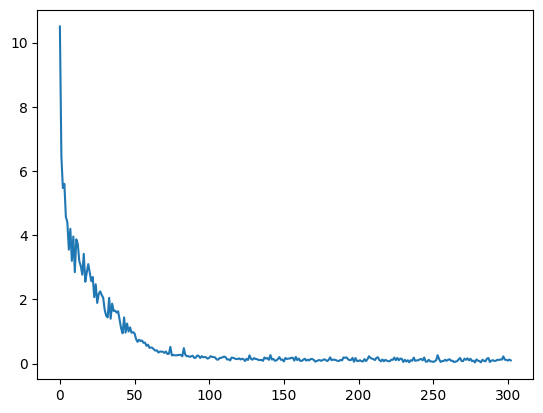

In [43]:
plt.plot(nums[::100])